In [15]:
import numpy as np # linear algebra
import pandas as pd

## Arima Model

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [17]:
df = pd.read_csv('prices-split-adjusted.csv', index_col=0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [18]:
# Filter dataframe only for chosen ticker symbol
dfa = df[df['symbol'] == 'AAPL']
dfa.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [19]:
dfa.index.sort_values()

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
      dtype='object', name='date', length=1762)

In [20]:
# Convert index to pandas datetime
dfa.index = pd.to_datetime(dfa.index, format="%Y/%m/%d")

In [21]:
df_final = dfa.drop(['symbol','open','low','high','volume'], axis=1)

In [22]:
# Conver to Series to run Dickey-Fuller test
df_final = pd.Series(df_final['close'])

## Check Stationary

In [23]:
def check_stationarity(ts_data):
    
    # Rolling statistics
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(5).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))
    

Dickey-Fuller test results

Test Statistic      -1.324458
p-value              0.617910
# of lags            0.000000
# of obs          1761.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


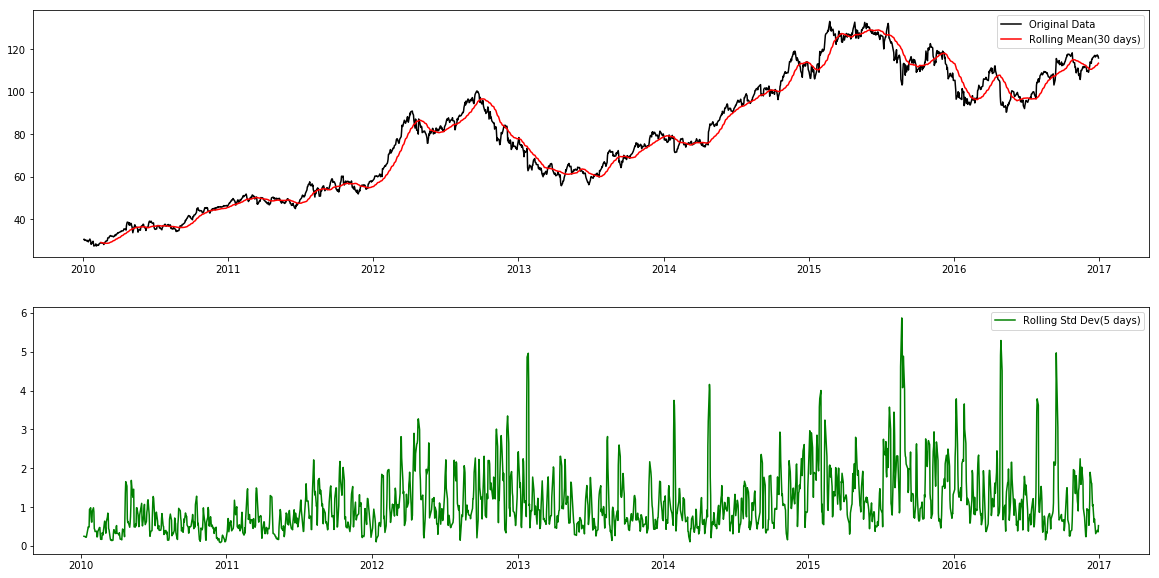

In [24]:
check_stationarity(df_final)

## Log Transformation of original Time series

In [25]:
# Log transform time series
df_final_log = np.log(df_final)
df_final_log.head()

date
2010-01-04    3.420113
2010-01-05    3.421840
2010-01-06    3.405806
2010-01-07    3.403955
2010-01-08    3.410582
Name: close, dtype: float64

Dickey-Fuller test results

Test Statistic      -1.909807
p-value              0.327462
# of lags            0.000000
# of obs          1761.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


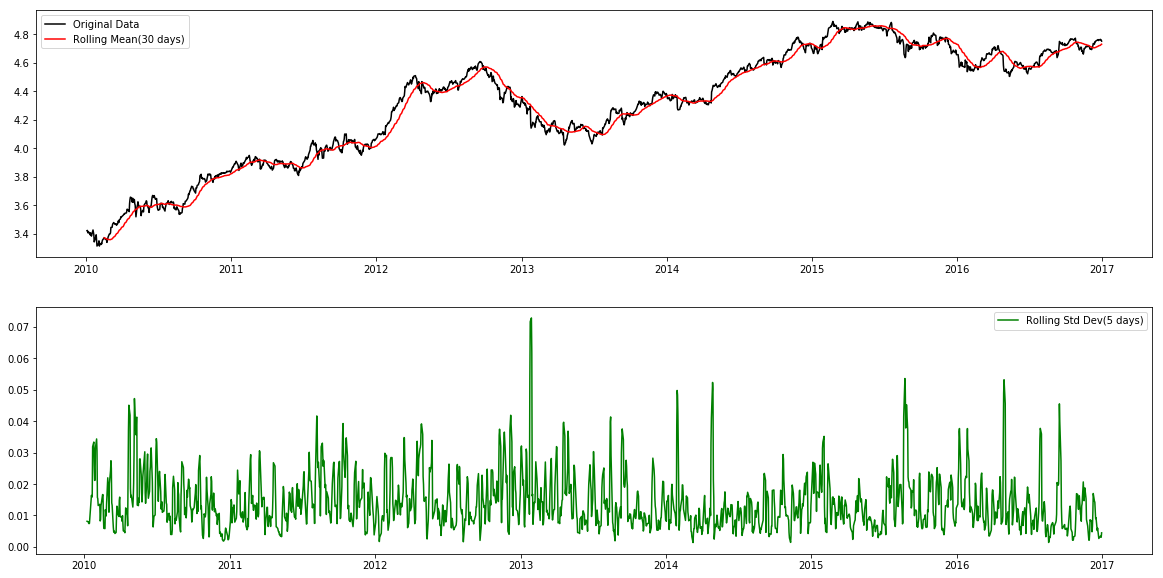

In [26]:
# Check stationarity
df_final_log.dropna(inplace=True)
check_stationarity(df_final_log)

### Log transformation is not stationary as test statistics is greater than critical value.

### Log differencing transformation of original time series

In [27]:
# Log Differencing
df_final_log_diff = df_final_log - df_final_log.shift()

Dickey-Fuller test results

Test Statistic     -40.914822
p-value              0.000000
# of lags            0.000000
# of obs          1760.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


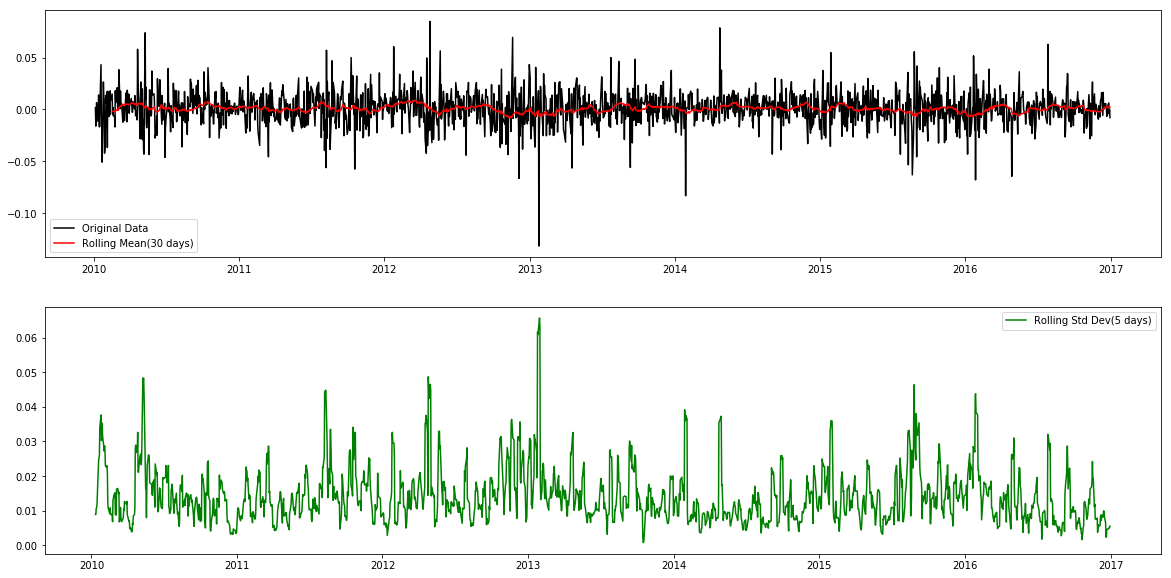

In [28]:
df_final_log_diff.dropna(inplace=True)
check_stationarity(df_final_log_diff)

### Simple differencing transform of original time series

In [29]:
# Differencing
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic     -41.122158
p-value              0.000000
# of lags            0.000000
# of obs          1760.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


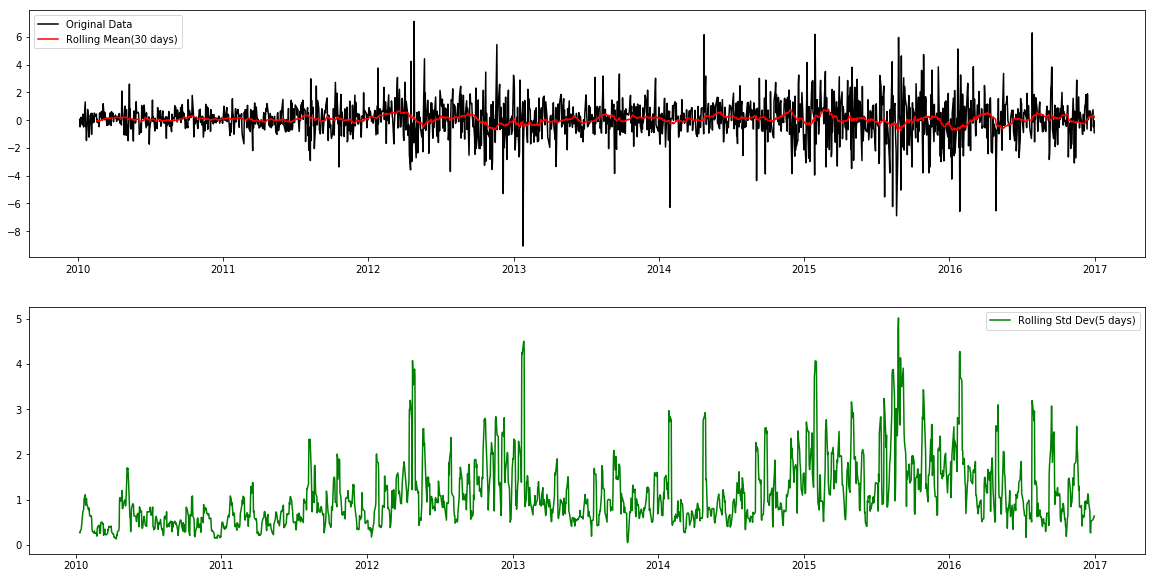

In [30]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

### As simple diiferencing prodices a test statistics is which is much lower than critical values,we will use this for ARIMA model

C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


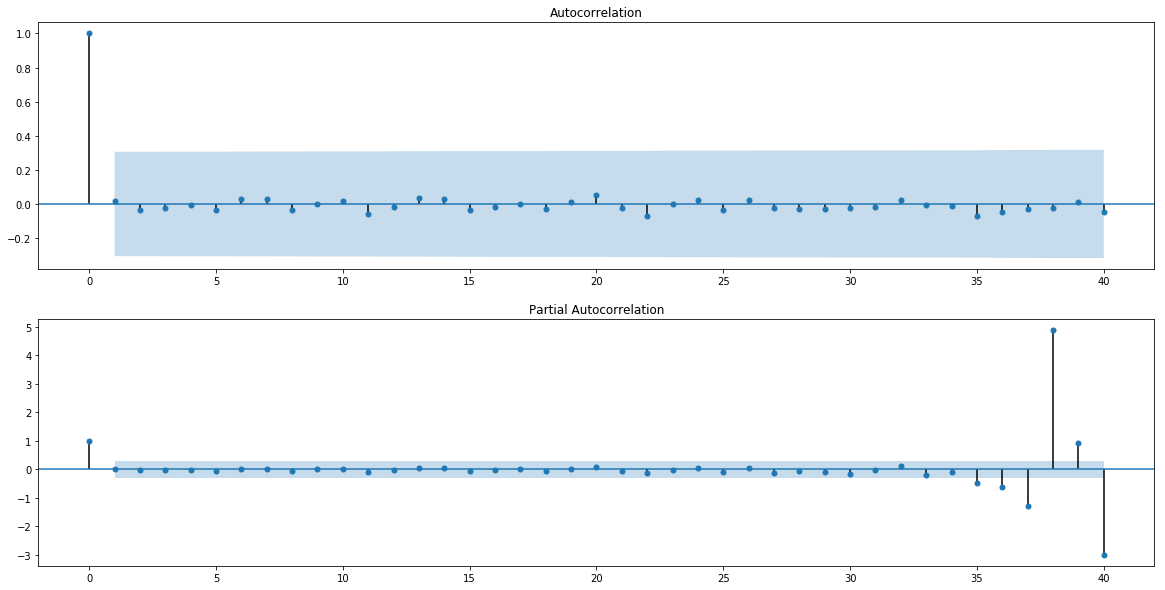

In [31]:
from statsmodels.tsa.stattools import acf, pacf
df_acf = acf(df_final_diff)
df_pacf = pacf(df_final_diff)
df_pacf = pacf(df_final_diff)
import statsmodels.api as sm
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_pacf, ax=ax2)


In [32]:
model = ARIMA(df_final_diff, (1,1,0))
fit_model = model.fit(full_output=True)
predictions = model.predict(fit_model.params, start=1760, end=1769)
fit_model.summary()

C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\LENOVO\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: Futu

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1760
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3376.018
Method:                       css-mle   S.D. of innovations              1.647
Date:                Thu, 07 Mar 2019   AIC                           6758.035
Time:                        18:53:51   BIC                           6774.454
Sample:                             1   HQIC                          6764.103
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.027     -0.011      0.991      -0.052       0.052
ar.L1.D.close    -0.4772      0.021    -22.794      0.000      -0.518      -0.436
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0954           +0.0000j            2.0954            0.5000
-----------------------------------------------------------------------------
"""

In [33]:
predictions

array([-0.22472244,  0.41954225, -0.20064195,  0.09532939, -0.04591741,
        0.02148999, -0.01067893,  0.00467309, -0.00265338,  0.00084304])

In [34]:
fit_model.predict(start=1760, end=1769)

C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1759   -0.224722
1760    0.419542
1761   -0.200642
1762    0.095329
1763   -0.045917
1764    0.021490
1765   -0.010679
1766    0.004673
1767   -0.002653
1768    0.000843
dtype: float64

### Re-transfer data to original scale

In [35]:
pred_model_diff = pd.Series(fit_model.fittedvalues, copy=True)
pred_model_diff.head()

date
2010-01-06   -0.000287
2010-01-07    0.257281
2010-01-08   -0.206315
2010-01-11   -0.122458
2010-01-12    0.222512
dtype: float64

In [36]:
# Calculate cummulative sum of the fitted values (cummulative sum of differences)
pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

date
2010-01-06   -0.000287
2010-01-07    0.256995
2010-01-08    0.050680
2010-01-11   -0.071778
2010-01-12    0.150734
dtype: float64

In [37]:
# Element-wise addition back to original time series
df_final_trans = df_final.add(pred_model_diff_cumsum, fill_value=0)
# Last 5 rows of fitted values
df_final_trans.tail()

date
2016-12-23    116.169622
2016-12-27    116.431976
2016-12-28    115.688160
2016-12-29    116.249507
2016-12-30    115.114782
dtype: float64

In [38]:
# Last 5 rows of original time series
df_final.tail()

date
2016-12-23    116.519997
2016-12-27    117.260002
2016-12-28    116.760002
2016-12-29    116.730003
2016-12-30    115.820000
Name: close, dtype: float64

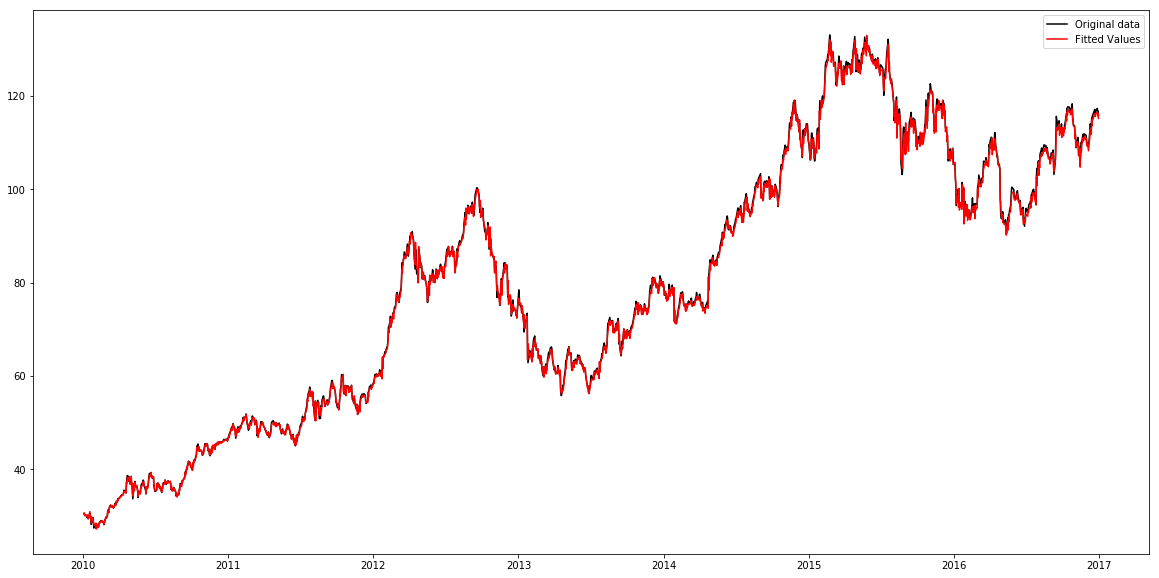

In [39]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20,10))
plt.plot(df_final, color='black', label='Original data')
plt.plot(df_final_trans, color='red', label='Fitted Values')
plt.legend()

In [40]:
x = df_final.values
y = df_final_trans.values

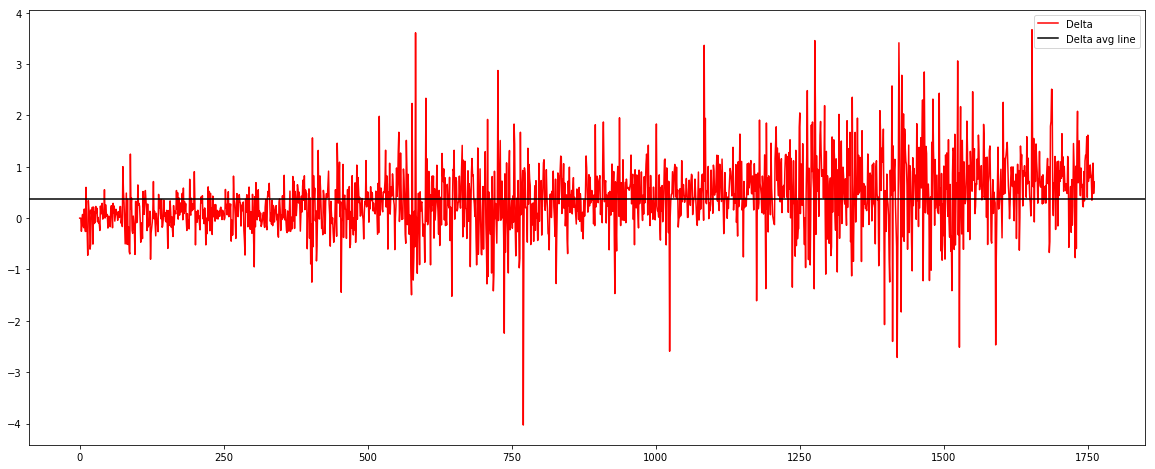

In [41]:
# Trend of error
plt.figure(figsize=(20,8))
plt.plot((x - y), color='red', label='Delta')
plt.axhline((x-y).mean(), color='black', label='Delta avg line')
plt.legend()

Average errors are $0.35 per share

### Ten Prediction values

In [42]:
final_pred = []
for i in predictions:
    t = df_final[-1] + i
    final_pred.append(t)
final_pred = pd.Series(final_pred)
final_pred    

0    115.595278
1    116.239542
2    115.619358
3    115.915329
4    115.774083
5    115.841490
6    115.809321
7    115.824673
8    115.817347
9    115.820843
dtype: float64